In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install rdkit


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 10.5 MB/s eta 0:00:00


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import chi2
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from rdkit import Chem,DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors, Lipinski, Draw
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AML Group/clean_data3.csv')
data.head()

,Unnamed: 0,molecule_chembl_id,smiles,standard_type,standard_value,standard_units,MW,LogP,NumHDonors,NumHAcceptors,AR,RB,bioactivity_class,bioactivity_class_encoded
0,0,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,33.0,nM,295.810,2.8477,0.0,3.0,1.0,2.0,active,0
1,1,CHEMBL1790051,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccccc1)N2C.Cl,Ki,314.0,nM,295.810,2.8477,0.0,3.0,1.0,2.0,inactive,1
2,2,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,32.0,nM,303.358,1.8677,0.0,5.0,1.0,3.0,active,0
3,3,CHEMBL370805,COC(=O)[C@H]1[C@@H](OC(=O)c2ccccc2)C[C@@H]2CC[...,Ki,388.0,nM,303.358,1.8677,0.0,5.0,1.0,3.0,inactive,1
4,4,CHEMBL333280,CN1CCC(O)(c2ccc(Cl)c(Cl)c2)C([C@@H](O)c2ccc(Cl...,Ki,4140.0,nM,435.178,5.1731,2.0,3.0,2.0,3.0,inactive,1


In [ ]:
#FINGERPRINTS

def generate_fingerprint(smiles):

    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    return fingerprint

In [ ]:
fingerprint = data["smiles"].apply(generate_fingerprint)
fingerprint

0       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
                              ...                        
5899    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
5900    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5901    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5902    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5903    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: smiles, Length: 5904, dtype: object

In [ ]:
#convert the fingerprint to a numpy array
def rdkit_numpy_convert(fp):
    output=[]
    for f in fp:
        arr=np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f,arr)
        output.append(arr)
    return np.asarray(output)
        


In [ ]:
X=rdkit_numpy_convert(fingerprint)    
X.shape
#ALL molecules have 2048 molecule fingerprint

(5904, 2048)

In [ ]:
y = data.iloc[:,13]

In [ ]:
#CNN
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
model = Sequential()

# Adding a 1D convolutional layer with 32 filters, each of size 3, and 'relu' activation
model.add(Conv1D(32, 3, activation='relu', input_shape=x_train.shape[1:]))

# Adding max pooling layer with pool size 2
model.add(MaxPooling1D(pool_size=2))

# Flattening the input
model.add(Flatten())

# Adding a dense layer with 128 units and 'relu' activation
model.add(Dense(128, activation='relu'))

# Adding the output layer with appropriate number of units based on the problem
model.add(Dense(1, activation='sigmoid')) # For binary classification

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
148/148 [==============================] - 17s 105ms/step - loss: 0.4132 - accuracy: 0.8124
Epoch 2/50
148/148 [==============================] - 16s 106ms/step - loss: 0.3130 - accuracy: 0.8584
Epoch 3/50
148/148 [==============================] - 16s 109ms/step - loss: 0.2709 - accuracy: 0.8770
Epoch 4/50
148/148 [==============================] - 16s 111ms/step - loss: 0.2439 - accuracy: 0.8910
Epoch 5/50
148/148 [==============================] - 16s 109ms/step - loss: 0.2194 - accuracy: 0.8999
Epoch 6/50
148/148 [==============================] - 16s 108ms/step - loss: 0.2012 - accuracy: 0.9145
Epoch 7/50
148/148 [==============================] - 16s 111ms/step - loss: 0.1872 - accuracy: 0.9168
Epoch 8/50
148/148 [==============================] - 17s 116ms/step - loss: 0.1770 - accuracy: 0.9185
Epoch 9/50
148/148 [==============================] - 17s 112ms/step - loss: 0.1713 - accuracy: 0.9206
Epoch 10/50
148/148 [==============================] - 17s 113ms/step - l

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# assuming X and y are already defined and the model is trained

# evaluate the model on the test set
loss, accuracy = model.evaluate(X, y)
print('Test accuracy:', accuracy)


185/185 [==============================] - 4s 22ms/step - loss: 0.2155 - accuracy: 0.9231
Test accuracy: 0.9231029748916626


In [ ]:
y_pred = model.predict(X)
y_pred_binary = (y_pred > 0.5).astype(int)
print(classification_report(y, y_pred_binary))


185/185 [==============================] - 6s 34ms/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1665
           1       0.95      0.94      0.95      4239

    accuracy                           0.92      5904
   macro avg       0.90      0.91      0.91      5904
weighted avg       0.92      0.92      0.92      5904



In [ ]:
print(confusion_matrix(y, y_pred_binary))

[[1467  198]
 [ 256 3983]]


In [ ]:
score = model.evaluate(x_test, y_test, batch_size=32)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

37/37 [==============================] - 2s 55ms/step - loss: 0.6787 - accuracy: 0.8281
Test loss: 0.678713858127594
Test accuracy: 0.8281117677688599


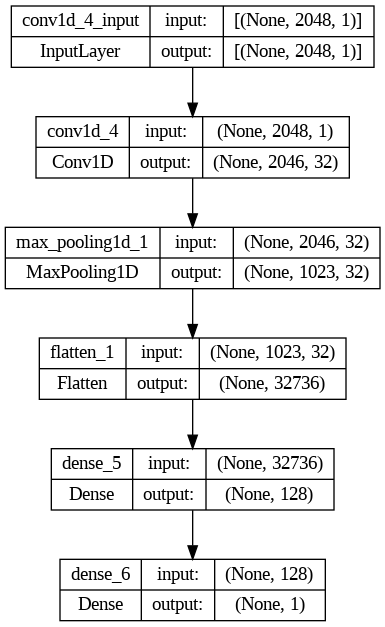

In [ ]:
from IPython.display import Image
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)
Image('model.png')

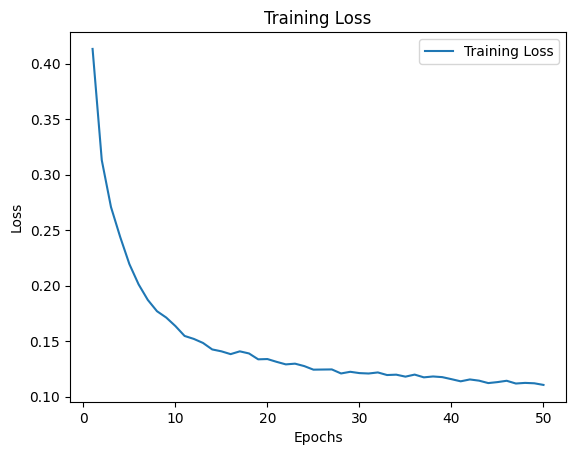

In [ ]:
training_loss = history.history['loss']
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()